# Mortality Aggregation

Benjamin Frost 2022


In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from scipy.interpolate import interp1d
from Categorization import Categorizer
import torch
import copy
from torch.nn.functional import one_hot
import imblearn
from collections import Counter
from tslearn.clustering import TimeSeriesKMeans
from tslearn.utils import to_time_series_dataset
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.metrics import silhouette_score
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from dask.dataframe import from_pandas
from tsfresh.utilities.distribution import MultiprocessingDistributor
import hashlib 
from sklearn.metrics import precision_recall_fscore_support
from importlib import reload
from temporalHelper import TemporalHelper as TH

### Loading in the mimic dataset

In [2]:
th = TH()

mimicDF = th.get_mimic()

mimicDF

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
0,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,178177,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47083,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47084,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47085,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47086,159740,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
mimicDF.describe()

,PatientID,Mortality14Days,ALT,AST,Admit Ht,Albumin,Arterial BP Mean,Arterial BP [Diastolic],Arterial BP [Systolic],Arterial PaCO2,...,SVI,SVR,SVRI,SaO2,Sodium,SpO2,SvO2,Temperature C,Total Bili,WBC
count,47088.000000,47088.000000,484.000000,481.000000,705.000000,245.000000,31415.000000,31503.000000,31504.000000,8601.000000,...,12981.000000,14768.000000,14714.000000,4352.000000,2485.000000,32961.000000,85.000000,26516.000000,331.000000,2118.000000
mean,151079.910805,0.039755,630.123967,954.301455,67.382553,2.721633,77.058157,57.226709,117.544502,40.565399,...,33.217492,987.290546,1917.421073,96.799012,138.022942,97.267665,64.988235,37.235334,2.529305,12.747691
std,29378.613191,0.195386,1245.805613,2384.326867,5.448469,0.584693,14.324177,11.197415,21.311674,7.078312,...,10.474703,363.504762,608.801780,2.659592,5.435978,3.083466,10.518118,1.399548,3.004787,5.523420
min,100059.000000,0.000000,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,...,0.000000,0.000000,0.000000,42.000000,1.210000,0.000000,43.000000,0.000000,0.000000,1.900000
25%,126241.000000,0.000000,25.000000,49.000000,64.000000,2.400000,68.000000,50.000000,103.000000,36.000000,...,26.168200,737.500000,1494.877533,96.000000,136.000000,96.000000,58.000000,36.900002,0.600000,9.000000
50%,151857.000000,0.000000,97.000000,137.000000,68.000000,2.700000,75.000000,56.000000,115.000000,40.000000,...,31.460699,931.028503,1841.049988,97.000000,138.000000,98.000000,65.000000,37.299999,1.400000,11.900000
75%,176484.000000,0.000000,554.750000,797.000000,70.000000,3.000000,84.000000,63.000000,129.000000,44.000000,...,38.118801,1169.229980,2244.340088,98.000000,140.000000,100.000000,71.000000,37.700001,3.300000,15.500000
max,199998.000000,1.000000,8100.000000,23060.000000,160.000000,4.400000,287.000000,191.000000,255.000000,91.000000,...,179.212997,3784.620117,6000.000000,100.000000,164.000000,100.000000,100.000000,46.500000,16.400000,48.300000


In [4]:
print(f"There are {mimicDF['PatientID'].nunique()} unique patients in the dataset")

There are 1126 unique patients in the dataset


In [5]:
patients = th.get_patients()

print(len(patients))

100%|██████████| 1126/1126 [00:01<00:00, 945.96it/s]

1126


### Aggregating the dataset using expert values

In [6]:
# Aggregating the dataset

staticPatients = []

target = []

for patient in patients:

    curr = {}

    df = patient.data

    curr['PatientID'] = patient.patientID
    target.append(patient.label)
    curr['ALT'] = df['ALT'].max()
    curr['AST'] = df['AST'].max()
    curr['Admit_Ht'] = df['Admit Ht'].max()
    curr['Albumin'] = df['Albumin'].min()
    curr['Arterial_BP_Mean'] = df['Arterial BP Mean'].min()
    curr['Arterial_BP_Diastolic'] = df['Arterial BP [Diastolic]'].min()
    curr['Arterial_BP_Systolic'] = df['Arterial BP [Systolic]'].min()
    curr['Arterial_PaCO2'] = df['Arterial PaCO2'].min()
    curr['Arterial_PaO2'] = df['Arterial PaO2'].min()
    curr['Arterial_pH_Max'] = df['Arterial pH'].max()
    curr['Arterial_pH_Min'] = df['Arterial pH'].min()
    curr['Urea'] = df['BUN'].min() * 0.357
    curr['CVP_Min'] = df['CVP'].min()
    curr['CVP_Max'] = df['CVP'].max()
    curr['CaO2'] = df['CaO2'].min()
    curr['Chloride'] = df['Chloride'].min()
    curr['Creatinine'] = df['Creatinine'].min()
    curr['Daily_Weight'] = df['Daily Weight'].loc[df['Daily Weight'].first_valid_index()] / 2.205 if df['Daily Weight'].first_valid_index() is not None else None
    curr['Fibrinogen'] = df['Fibrinogen'].max()
    curr['Glucose_Max'] = df['Glucose'].max()
    curr['Glucose_Min'] = df['Glucose'].min()
    curr['Heart_Rate_Min'] = df['Heart Rate'].min()
    curr['Heart_Rate_Max'] = df['Heart Rate'].max()
    curr['Hamoglobin'] = df['Hemoglobin'].min()
    curr['INR'] = df['INR'].max()
    curr['Ionized_Calcium'] = df['Ionized Calcium'].min()
    curr['LDH'] = df['LDH'].max()
    curr['Magnesium'] = df['Magnesium'].min()
    curr['NBP_Mean'] = df['NBP Mean'].min()
    curr['NBP_Diastolic'] = df['NBP [Diastolic]'].min()
    curr['NBP_Systolic'] = df['NBP [Systolic]'].min()
    curr['PTT'] = df['PTT'].max()
    curr['Platelets'] = df['Platelets'].min()
    curr['Potassium_Max'] = df['Potassium'].max()
    curr['Potassium_Min'] = df['Potassium'].min()
    curr['Resp_Rate_(Spont)_Min'] = df['Resp Rate (Spont)'].min()
    curr['Resp_Rate_(Spont)_Max'] = df['Resp Rate (Spont)'].max()
    curr['SVI'] = df['SVI'].min()
    curr['SVRI_Max'] = df['SVRI'].max()
    curr['SVRI_Min'] = df['SVRI'].min()
    curr['SaO2'] = df['SaO2'].min()
    curr['Sodium_Max'] = df['Sodium'].max()
    curr['Sodium_Min'] = df['Sodium'].min()
    curr['SpO2'] = df['SpO2'].min()
    curr['SvO2_Max'] = df['SvO2'].max()
    curr['SvO2_Min'] = df['SvO2'].min()
    curr['Temperature_C_Max'] = df['Temperature C'].max()
    curr['Temperature_C_Min'] = df['Temperature C'].min()
    curr['Bilirubin'] = df['Total Bili'].max()
    curr['White_Blood_Cells_Max'] = df['WBC'].max()
    curr['White_Blood_Cells_Min'] = df['WBC'].min()

    staticPatients.append(curr)


staticPatientsDF = pd.DataFrame([x.values() for x in staticPatients], columns=curr.keys())

staticPatientsDF = staticPatientsDF.set_index('PatientID')

targetSeries = pd.Series(data=target)

In [7]:
staticPatientsDF.describe()

,ALT,AST,Admit_Ht,Albumin,Arterial_BP_Mean,Arterial_BP_Diastolic,Arterial_BP_Systolic,Arterial_PaCO2,Arterial_PaO2,Arterial_pH_Max,...,Sodium_Max,Sodium_Min,SpO2,SvO2_Max,SvO2_Min,Temperature_C_Max,Temperature_C_Min,Bilirubin,White_Blood_Cells_Max,White_Blood_Cells_Min
count,253.000000,250.000000,663.000000,143.000000,1096.000000,1097.000000,1097.000000,1075.000000,1075.000000,1083.000000,...,742.000000,742.000000,1126.00000,49.000000,49.000000,1126.000000,1126.000000,171.000000,731.000000,731.000000
mean,388.296443,652.108000,67.376471,2.613287,60.073905,43.779398,87.995442,34.494884,90.542763,7.607101,...,139.758760,136.113221,91.58659,68.367347,66.040816,37.029165,35.332380,2.094737,14.690014,11.269494
std,1014.823729,2053.610608,5.529188,0.584451,9.878763,11.453517,21.175211,5.266344,34.024617,5.456490,...,3.570727,7.843155,8.97472,11.305776,11.193300,5.621109,5.680826,2.696976,6.032519,4.910463
min,3.000000,3.000000,48.000000,1.400000,0.000000,0.000000,0.000000,15.000000,7.470000,7.230000,...,127.000000,1.210000,0.00000,45.000000,43.000000,0.000000,0.000000,0.100000,2.400000,1.900000
25%,19.000000,40.000000,64.000000,2.200000,55.000000,40.000000,82.000000,31.000000,70.000000,7.410000,...,138.000000,134.000000,91.00000,60.000000,57.000000,37.500000,35.700001,0.600000,10.600000,7.800000
50%,40.000000,79.500000,68.000000,2.600000,60.000000,45.000000,90.000000,35.000000,82.000000,7.440000,...,140.000000,136.000000,93.00000,69.000000,67.000000,37.900002,36.299999,1.000000,13.600000,10.600000
75%,220.000000,359.000000,70.000000,3.000000,65.000000,50.000000,98.000000,38.000000,102.500000,7.470000,...,142.000000,139.000000,95.00000,74.000000,74.000000,38.299999,36.900002,2.400000,17.550000,13.850000
max,8100.000000,23060.000000,160.000000,4.400000,106.000000,77.000000,170.000000,66.000000,389.000000,187.000000,...,164.000000,152.000000,100.00000,100.000000,98.000000,46.500000,38.900002,16.400000,48.300000,48.300000


In [8]:
rowsWithNaN = sum(staticPatientsDF.isnull().any(axis=1))
print(f"{staticPatientsDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

1126 rows in df, 1124 containing NaN values


### Filling the missing values from aggregated data

In [31]:
fillNaModeDF = staticPatientsDF.copy()

for col in fillNaModeDF:
    fillNaModeDF[col] = fillNaModeDF[col].fillna(fillNaModeDF[col].mean())

fillNaModeDF['Admit_Ht'][fillNaModeDF["Admit_Ht"] > 100] = fillNaModeDF["Admit_Ht"].mean()

display(fillNaModeDF)

,ALT,AST,Admit_Ht,Albumin,Arterial_BP_Mean,Arterial_BP_Diastolic,Arterial_BP_Systolic,Arterial_PaCO2,Arterial_PaO2,Arterial_pH_Max,...,Sodium_Max,Sodium_Min,SpO2,SvO2_Max,SvO2_Min,Temperature_C_Max,Temperature_C_Min,Bilirubin,White_Blood_Cells_Max,White_Blood_Cells_Min
PatientID,,,,,,,,,,,,,,,,,,,,,
100059,388.296443,652.108,66.000000,2.613287,60.0,43.0,106.0,39.0,83.0,7.45,...,149.00000,137.000000,94.0,68.367347,66.040816,37.700001,36.200001,2.094737,13.300000,9.900000
100298,388.296443,652.108,68.000000,2.613287,62.0,48.0,81.0,33.0,77.0,7.49,...,140.00000,137.000000,92.0,68.367347,66.040816,38.500000,36.500000,2.094737,25.200000,21.200000
100321,388.296443,652.108,59.000000,2.613287,59.0,41.0,86.0,32.0,122.0,7.46,...,139.75876,136.113221,92.0,68.367347,66.040816,37.099998,35.099998,2.094737,14.690014,11.269494
100336,304.000000,780.000,72.000000,2.100000,63.0,53.0,80.0,26.0,25.0,7.47,...,140.00000,131.000000,46.0,68.367347,66.040816,37.099998,33.200001,0.400000,17.700000,12.700000
100392,388.296443,652.108,69.000000,2.613287,56.0,45.0,80.0,43.0,66.0,7.38,...,140.00000,137.000000,88.0,68.367347,66.040816,38.900002,35.599998,2.094737,19.500000,11.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199876,388.296443,652.108,67.376471,2.613287,57.0,37.0,93.0,38.0,78.0,7.40,...,139.75876,136.113221,95.0,68.367347,66.040816,37.599998,37.000000,2.094737,14.690014,11.269494
199877,388.296443,652.108,67.376471,2.613287,63.0,51.0,134.0,38.0,122.0,7.44,...,139.75876,136.113221,97.0,68.367347,66.040816,37.099998,36.599998,2.094737,14.690014,11.269494
199963,388.296443,652.108,72.000000,2.613287,56.0,42.0,82.0,30.0,105.0,7.42,...,140.00000,136.000000,94.0,68.367347,66.040816,38.200001,36.200001,2.094737,20.100000,14.600000


### Binning with K-Bins

{'ALT': [2791.0, 6870.0],
 'AST': [7989.0, 23060.0],
 'Admit_Ht': [58.0, 68.0],
 'Albumin': [2.5, 3.5],
 'Arterial_BP_Mean': [36.0, 71.0],
 'Arterial_BP_Diastolic': [26.0, 52.0],
 'Arterial_BP_Systolic': [57.0, 114.0],
 'Arterial_PaCO2': [32.0, 49.0],
 'Arterial_PaO2': [135.0, 281.0],
 'Arterial_pH_Max': [187.0],
 'Arterial_pH_Min': [7.11, 7.3],
 'Urea': [14.994, 29.988],
 'CVP_Min': [8.0, 15.0],
 'CVP_Max': [18.0, 34.0],
 'CaO2': [7.688059807, 14.1566],
 'Chloride': [99.0, 111.0],
 'Creatinine': [3.9, 8.3],
 'Daily_Weight': [40.27211022675737, 67.57369614512471],
 'Fibrinogen': [358.0, 645.0],
 'Glucose_Max': [261.0, 467.0],
 'Glucose_Min': [148.0, 270.0],
 'Heart_Rate_Min': [46.0, 92.0],
 'Heart_Rate_Max': [108.0, 166.0],
 'Hamoglobin': [6.0, 11.5],
 'INR': [27.0],
 'Ionized_Calcium': [0.76, 1.03],
 'LDH': [4412.0, 9830.0],
 'Magnesium': [2.1, 3.3],
 'NBP_Mean': [37.66669846, 75.66670227],
 'NBP_Diastolic': [33.0, 66.0],
 'NBP_Systolic': [78.0, 158.0],
 'PTT': [64.4, 107.9],
 'Platel

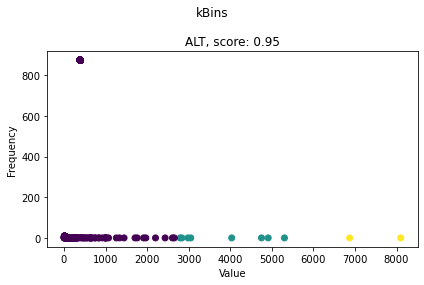

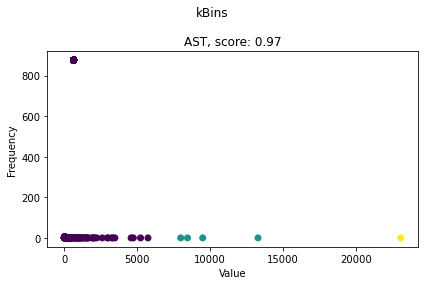

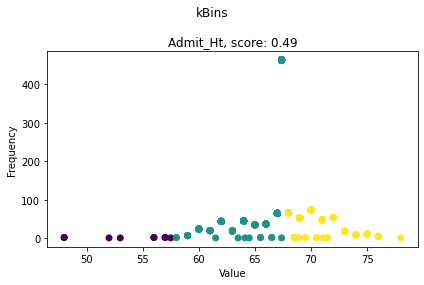

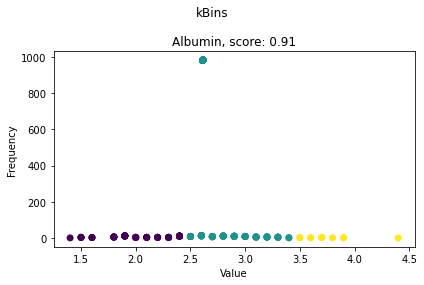

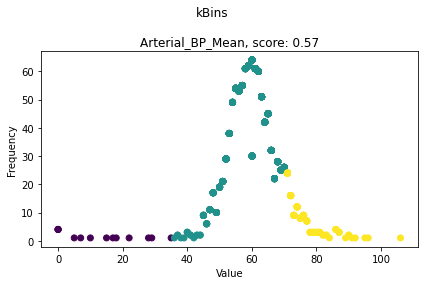

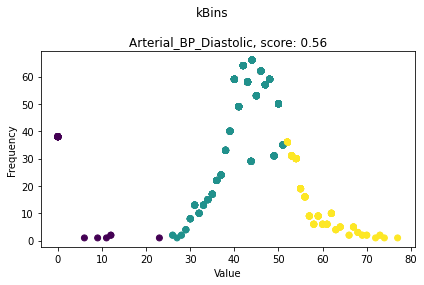

In [41]:
import Categorization

reload(Categorization)

cat = Categorization.Categorizer(fillNaModeDF)

cat.kBins(bins = 3)

boundaries = cat.getBoundaries()

display(boundaries['kBins'])

cat.display(num=6)

### Labelling high to low

In [35]:
categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}

cat.map_types(mapping=categories)

mapped = cat.mappedTypes['kBins']

mapped

,ALT_high,ALT_low,ALT_medium,AST_high,AST_low,AST_medium,Admit_Ht_high,Admit_Ht_low,Admit_Ht_medium,Albumin_high,...,Temperature_C_Min_low,Bilirubin_high,Bilirubin_low,Bilirubin_medium,White_Blood_Cells_Max_high,White_Blood_Cells_Max_low,White_Blood_Cells_Max_medium,White_Blood_Cells_Min_high,White_Blood_Cells_Min_low,White_Blood_Cells_Min_medium
0,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,1
2,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
3,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
4,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1121,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1122,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1123,0,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,1,0,1,0
1124,0,1,0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0


In [36]:
targetSeries.value_counts()

0    1077
1      49
dtype: int64

In [37]:
mapped['Mortality14Days'] = targetSeries.values

mapped.to_csv("./categorisedData/expertLabelledData.csv")